In [1]:
import pandas as pd
import sklearn.tree as sktree
import scipy as sp
import os
path="C:/Users/SAMSUNG/Desktop/decisiontree"
filename=os.listdir(path)

## 변수설정

### Target(Y)

target = 침수여부

In [2]:
target=pd.read_csv(path+"/침수지역2022.csv")

위의 데이터는 침수지역의 빈도(frequency)이므로 바꿔야함

In [3]:
print('한번이라도 침수가 일어난 지역수(행정동) :',target["ADM_NM"].nunique())

한번이라도 침수가 일어난 지역수(행정동) : 277


In [4]:
target["ADM_NM"]

0         우이동
1         우이동
2         우이동
3        영등포동
4         송중동
        ...  
8882      청파동
8883      한남동
8884    원효로2동
8885      동선동
8886    북가좌2동
Name: ADM_NM, Length: 8887, dtype: object

In [5]:
target["ADM_CD"]

0       1130510400
1       1130510400
2       1130510400
3       1156010400
4       1130510100
           ...    
8882    1117013100
8883    1117010800
8884    1117011300
8885    1129010300
8886    1141011900
Name: ADM_CD, Length: 8887, dtype: int64

In [6]:
target["ADM_CD_2"]

0       1109074
1       1109074
2       1109074
3       1119074
4       1109071
         ...   
8882    1103071
8883    1103074
8884    1103057
8885    1108083
8886    1113072
Name: ADM_CD_2, Length: 8887, dtype: int64

### Feature(X)

In [7]:
filename

['2. 가공데이터',
 '경사도.xlsx',
 '도로현황(도로율)_20231015181102.csv',
 '반출_행정동_소득가구_수정.xlsx',
 '반출_행정동_소득가구_수정2차.xlsx',
 '배수등급양호비율.csv',
 '서울시_강우량_정보_2022년',
 '서울시_행정동별_인구밀도_2023.csv',
 '여성.csv',
 '장애인.csv',
 '재해위험지구_경계도.csv',
 '제방.csv',
 '제방암거수문_있다없다.csv',
 '제방암거수문개수.csv',
 '침수지역2022.csv',
 '침수흔적도2022.csv',
 '토양도',
 '하천까지의_거리.csv',
 '행정동_공시지가_2020.xlsx',
 '행정동_법정동.ipynb']

In [8]:
경사도=pd.read_excel(path+"/경사도.xlsx")
행정공시지가=pd.read_excel(path+"/"+'행정동_공시지가_2020.xlsx')
도로율=pd.read_csv(path+"/"+"도로현황(도로율)_20231015181102.csv")
배수등급양호비율=pd.read_csv(path+"/"+"배수등급양호비율.csv")
하천까지의거리=pd.read_csv(path+"/"+'하천까지의_거리.csv')
제방암거수문=pd.read_csv(path+"/"+'제방암거수문_있다없다.csv')
인구밀도=pd.read_csv(path+"/"+'서울시_행정동별_인구밀도_2023.csv')
행정동소득분위=pd.read_excel(path+"/"+"반출_행정동_소득가구_수정2차.xlsx")

사회인프라

In [9]:
path2=path+"/"+'2. 가공데이터'

In [10]:
장애인=pd.read_csv(path2+"/"+"장애인.csv")
노인=pd.read_csv(path2+"/"+'노인.csv')
기초수급자=pd.read_csv(path2+"/"+"기초수급자.csv")
기초수급자_65세이상=pd.read_csv(path2+"/"+'기초생활수급자+65세이상.csv')

강우량

In [11]:
path3=path+"/"+'서울시_강우량_정보_2022년'

In [12]:
rain_dict={}
for i in range(1,10):
    rain_dict[i]=pd.read_csv(path3+"/"+f'서울시_강우량_정보_2022년0{i}월.csv',encoding='euc-kr')
for j in range(10,13):
    rain_dict[j]=pd.read_csv(path3+"/"+f'서울시_강우량_정보_2022년{j}월.csv',encoding='euc-kr')

In [13]:
rain_data=pd.concat([rain_dict[i][rain_dict[i]["10분우량"]!=0] for i in range(1,13)])
rain_agg=rain_data.groupby(["구청명"])["10분우량"].agg(["sum","count"])
rain_agg.rename(columns=dict(zip(["sum","count"],["누적강수량","10분당 측정(횟수)"])),inplace=True)
rain_agg.index.rename(None,inplace=True)

In [14]:
rain_agg["추정시우량(연간)"]=rain_agg["누적강수량"]/(rain_agg["10분당 측정(횟수)"]/6)

In [15]:
rain_agg.index.rename("시군구",inplace=True)
rain_agg.reset_index(inplace=True)

In [16]:
구면적=pd.DataFrame(인구밀도.groupby(["구"])["면적 (k㎡)"].sum()).reset_index()
구면적.rename(columns={"구":"시군구"},inplace=True)

In [17]:
rain_agg=pd.merge(rain_agg,구면적)
rain_agg["추정면적당시우량(연간)"]=rain_agg["추정시우량(연간)"]/rain_agg["면적 (k㎡)"]

In [18]:
rain_agg

,시군구,누적강수량,10분당 측정(횟수),추정시우량(연간),면적 (k㎡),추정면적당시우량(연간)
0,강남구,6044.5,4063,8.926163,39.51,0.225922
1,강동구,3829.0,2745,8.369399,24.59,0.340358
2,강북구,1803.5,1382,7.829957,23.60,0.331778
3,강서구,3076.5,2574,7.171329,41.44,0.173053
4,관악구,3777.0,2609,8.686087,29.57,0.293747
5,광진구,1887.0,1353,8.368071,17.06,0.490508
6,구로구,3553.5,2333,9.138877,20.12,0.454219
7,금천구,3648.0,2539,8.620717,13.02,0.662113
8,노원구,3686.5,2816,7.854759,35.44,0.221635
9,도봉구,1932.0,1435,8.078049,20.65,0.391189


### 데이터 병합

행정동 단위
> 경사도, 행정공시지가, 배수등급양호비율, 하천까지의 거리, 제방수문암거

In [19]:
# import PublicDataReader as pdr
# 행정동코드 = pdr.code_hdong()
# import numpy as np
# 행정동=행정동코드[행정동코드["시도명"]=="서울특별시"][["시군구명","읍면동명"]]
# 행정동.index=행정동.index.astype('int')
# 행정동["시군구명"]=행정동["시군구명"].str.strip()
# 행정동["읍면동명"]=행정동["읍면동명"].str.strip()
# 행정동=행정동[행정동["시군구명"]!=""][행정동["읍면동명"]!=""]

----------

In [20]:
per_경사도=pd.DataFrame(경사도.groupby(["ADM_NM"])["경사도"].mean())
per_경사도.reset_index(inplace=True)

In [21]:
pre_경사도=pd.merge(경사도[["GU_NAME","ADM_NM"]],per_경사도,how='left')
pre_경사도["경사도(%)"]=pre_경사도["경사도"]*100
pre_경사도.drop_duplicates(["ADM_NM"],inplace=True)

In [22]:
pre_경사도

,GU_NAME,ADM_NM,경사도,경사도(%)
0,종로구,이화동,0.078333,7.833333
1,종로구,숭인2동,0.053125,5.312500
2,종로구,혜화동,0.078333,7.833333
3,중구,광희동,0.072500,7.250000
4,중구,을지로동,0.040000,4.000000
...,...,...,...,...
3234,관악구,난곡동,0.231667,23.166667
3427,금천구,시흥2동,0.377857,37.785714
3431,관악구,난향동,0.330000,33.000000
3464,금천구,독산2동,0.142667,14.266667


In [23]:
행정공시지가[행정공시지가.columns[[0,1,-1]]].rename(columns=dict(zip(행정공시지가.columns[[0,1]],["GU_NAME","ADM_NM"])))

,GU_NAME,ADM_NM,​평균공시지가(원/㎡)
0,중구,명동1가,56614016.0
1,중구,충무로1가,54595752.0
2,중구,명동2가,49435106.0
3,중구,을지로1가,42678973.0
4,중구,을지로2가,36948338.0
...,...,...,...
463,강서구,오곡동,243750.0
464,서초구,원지동,189153.0
465,강서구,개화동,175646.0
466,강북구,우이동,169341.0


In [24]:
배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]

,GU_NAME,ADM_NM,양호비율
0,송파구,가락1동,0.654167
1,송파구,가락2동,0.842105
2,송파구,가락본동,0.680000
3,구로구,가리봉동,0.688073
4,금천구,가산동,0.610245
...,...,...,...
412,용산구,효창동,0.980769
413,용산구,후암동,1.000000
414,동대문구,휘경1동,0.405797
415,동대문구,휘경2동,0.300578


In [25]:
하천까지의거리[["GU_NAME","ADM_NM","HubDist"]]

,GU_NAME,ADM_NM,HubDist
0,종로구,사직동,961.440982
1,종로구,삼청동,481.426072
2,종로구,부암동,719.095967
3,종로구,평창동,70.039725
4,종로구,무악동,1381.962564
...,...,...,...
419,강동구,둔촌1동,1112.581499
420,강동구,둔촌2동,286.658161
421,강동구,암사1동,1421.991249
422,강동구,천호2동,713.146580


In [26]:
제방암거수문
# 암거는 모두 가지고 있음

,GU_NAME,ADM_NM,비고,count,제방,수문,암거
0,강남구,개포1동,제방,65,1,1,1
1,강남구,개포1동,암거,58,1,1,1
2,강남구,개포1동,수문,4,1,1,1
3,강남구,개포2동,암거,95,1,1,1
4,강남구,개포2동,제방,30,1,1,1
...,...,...,...,...,...,...,...
833,중랑구,중화1동,암거,12,1,0,1
834,중랑구,중화1동,제방,4,1,0,1
835,중랑구,중화2동,암거,26,1,1,1
836,중랑구,중화2동,제방,12,1,1,1


In [27]:
인구밀도[["구","행정동","인구밀도(명/km²)"]]

,구,행정동,인구밀도(명/km²)
0,종로구,사직동,7618.699187
1,종로구,삼청동,1755.704698
2,종로구,부암동,4167.400881
3,종로구,평창동,2000.338219
4,종로구,무악동,22347.222220
...,...,...,...
421,강동구,둔촌1동,80.434783
422,강동구,둔촌2동,15520.512820
423,강동구,강일동,14638.053100
424,강동구,상일1동,21667.582420


In [28]:
행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]]

,읍면동,1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,사직동,0.158391,0.142992,0.214959,0.180704,0.302640
1,삼청동,0.240190,0.211653,0.229489,0.184304,0.133175
2,부암동,0.177386,0.169309,0.195334,0.212384,0.245588
3,평창동,0.119703,0.139261,0.173669,0.199565,0.367983
4,무악동,0.157974,0.118292,0.160620,0.181028,0.381708
...,...,...,...,...,...,...
418,성내3동,0.180404,0.192774,0.234538,0.218861,0.173423
419,둔촌2동,0.137338,0.148917,0.193626,0.235011,0.285108
420,암사1동,0.203770,0.215738,0.236557,0.199754,0.144180
421,천호2동,0.233815,0.231585,0.235276,0.192373,0.106951


In [29]:
행정동=pd.merge(배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]
             ,제방암거수문[["GU_NAME","ADM_NM","제방","수문"]],how="left")
행정동=pd.merge(행정동,pre_경사도,how='left')
행정동.drop("경사도",axis=1,inplace=True)
행정동.rename(columns={"양호비율":"배수등급양호비율","경사도(%)":"평균경사도(%)"},inplace=True)
행정동=pd.merge(행정동,하천까지의거리[["GU_NAME","ADM_NM","HubDist"]],how="left").rename(columns={"HubDist":"하천까지의거리(중심)"})
행정동=pd.merge(행정동,인구밀도[["구","행정동","인구밀도(명/km²)"]].rename(columns={"구":"GU_NAME","행정동":"ADM_NM"}),how="left")
행정동=pd.merge(행정동,행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]].rename(columns=
                                                                {'읍면동':"ADM_NM"}),how='left')
# 행정동=pd.merge(행정동
#              ,행정공시지가[행정공시지가.columns[[0,1,-1]]].rename(
#                  columns=dict(zip(행정공시지가.columns[[0,1]],["GU_NAME","ADM_NM"]))),how="left")


In [30]:
len(행정동)

830

In [31]:
행정동.head(3)

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,송파구,가락1동,0.654167,1.0,0.0,3.8125,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
1,송파구,가락1동,0.654167,1.0,0.0,3.8125,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
2,송파구,가락2동,0.842105,0.0,0.0,7.1250,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124


In [32]:
행정동.isna().sum()

GU_NAME          0
ADM_NM           0
배수등급양호비율         0
제방               2
수문               2
평균경사도(%)         6
하천까지의거리(중심)      0
인구밀도(명/km²)     23
1분위소득가구비율(%)    19
2분위소득가구비율(%)    19
3분위소득가구비율(%)    19
4분위소득가구비율(%)    19
5분위소득가구비율(%)    19
dtype: int64

Nan값 삭제

In [33]:
행정동.dropna(inplace=True)

--------

자치구별

In [34]:
도로율[["자치구별(2)","2022.2"]]

,자치구별(2),2022.2
0,자치구별(2),도로율 (%)
1,소계,23.35
2,종로구,21.15
3,중구,18.86
4,용산구,23.44
5,성동구,24.26
6,광진구,29.13
7,동대문구,22.74
8,중랑구,25.60
9,성북구,23.18


In [35]:
장애인[["동별(2)","장애인_per"]]

,동별(2),장애인_per
0,종로구,0.042206
1,중구,0.047262
2,용산구,0.035601
3,성동구,0.040202
4,광진구,0.036498
5,동대문구,0.046458
6,중랑구,0.053083
7,성북구,0.040730
8,강북구,0.059247
9,도봉구,0.049010


In [36]:
노인[["동별(2)","노인_per"]]

,동별(2),노인_per
0,종로구,0.184489
1,중구,0.189918
2,용산구,0.165642
3,성동구,0.156072
4,광진구,0.146727
5,동대문구,0.180027
6,중랑구,0.179242
7,성북구,0.168760
8,강북구,0.208990
9,도봉구,0.195573


In [37]:
rain_agg[["시군구","추정시우량(연간)"]]

,시군구,추정시우량(연간)
0,강남구,8.926163
1,강동구,8.369399
2,강북구,7.829957
3,강서구,7.171329
4,관악구,8.686087
5,광진구,8.368071
6,구로구,9.138877
7,금천구,8.620717
8,노원구,7.854759
9,도봉구,8.078049


In [38]:
시군구=pd.merge(도로율[["자치구별(2)","2022.2"]].loc[2:].rename(columns=dict(zip(["자치구별(2)","2022.2"],["동별(2)","도로율"])))
             ,노인[["동별(2)","노인_per"]])
시군구=pd.merge(시군구,장애인[["동별(2)","장애인_per"]])
시군구=pd.merge(시군구,기초수급자_65세이상[["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']].rename(
    columns=dict(zip(["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']
                     ,["동별(2)","기초생활수급자_per",'기초생활수급자+65세이상_per']))
))
시군구=pd.merge(시군구,rain_agg[["시군구","추정면적당시우량(연간)"]].rename(columns={"시군구":"동별(2)"}))
시군구[[y for y in 시군구.columns if "per" in y]]=시군구[[y for y in 시군구.columns if "per" in y]].applymap(lambda x:x*100)
시군구["도로율"]=시군구["도로율"].astype("float")

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_7732\211751531.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  시군구[[y for y in 시군구.columns if "per" in y]]=시군구[[y for y in 시군구.columns if "per" in y]].applymap(lambda x:x*100)


In [39]:
시군구

,동별(2),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간)
0,종로구,21.15,18.448941,4.220620,3.508514,1.578096,0.304153
1,중구,18.86,18.991788,4.726233,4.810223,2.285956,0.779388
2,용산구,23.44,16.564249,3.560130,3.952176,1.560540,0.347104
3,성동구,24.26,15.607165,4.020165,3.540936,1.468996,0.449988
4,광진구,29.13,14.672661,3.649844,3.890369,1.232481,0.490508
5,동대문구,22.74,18.002722,4.645774,4.781744,2.017811,0.552905
6,중랑구,25.60,17.924199,5.308269,6.875538,2.518254,0.419259
7,성북구,23.18,16.875989,4.072977,3.819461,1.485008,0.307104
8,강북구,17.77,20.898984,5.924687,7.236783,2.841112,0.331778
9,도봉구,23.93,19.557262,4.901019,4.748344,1.690083,0.391189


In [40]:
행정동

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
1,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,0.325271,0.261764,0.200230,0.136064,0.076670
826,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754
827,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754
828,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754


In [98]:
통합=pd.merge(행정동,시군구.rename(columns={"동별(2)":"GU_NAME"}),how="left")

In [100]:
침수여부=pd.DataFrame(target["ADM_NM"].unique(),columns=["ADM_NM"])

In [101]:
침수여부=pd.DataFrame(target["ADM_NM"].unique(),columns=["ADM_NM"])
침수여부["침수여부"]=1
통합=pd.merge(통합,침수여부,how="left")
통합.isna().sum() # Nan값 확인

GU_NAME                0
ADM_NM                 0
배수등급양호비율               0
제방                     0
수문                     0
평균경사도(%)               0
하천까지의거리(중심)            0
인구밀도(명/km²)            0
1분위소득가구비율(%)           0
2분위소득가구비율(%)           0
3분위소득가구비율(%)           0
4분위소득가구비율(%)           0
5분위소득가구비율(%)           0
도로율                    0
노인_per                 0
장애인_per                0
기초생활수급자_per            0
기초생활수급자+65세이상_per      0
추정면적당시우량(연간)           0
침수여부                 269
dtype: int64

In [102]:
# Nan값 -> 0 으로 쳐리하면 침수여부(0값)이 침수가 일어나지 않은 데이터로 바뀜
통합=통합.fillna(0)

In [103]:
통합.dropna(axis=0,inplace=True)

In [104]:
통합.drop_duplicates("ADM_NM",inplace=True)

In [105]:
통합

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수여부
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,1.0
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,1.0
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,1.0
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008,21.55,17.483236,4.669164,3.372114,1.338061,0.454219,1.0
5,금천구,가산동,0.610245,1.0,0.0,8.772727,468.909180,10567.85714,0.229826,0.267109,0.253626,0.144842,0.104597,22.37,17.127026,5.017209,5.388524,2.088480,0.662113,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,용산구,효창동,0.980769,1.0,0.0,12.666667,3363.536779,24777.27273,0.141448,0.149609,0.218293,0.233594,0.257395,23.44,16.564249,3.560130,3.952176,1.560540,0.347104,0.0
790,용산구,후암동,1.000000,1.0,0.0,39.625000,346.532474,19465.11628,0.216268,0.192485,0.234818,0.208181,0.148248,23.44,16.564249,3.560130,3.952176,1.560540,0.347104,0.0
792,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,0.325271,0.261764,0.200230,0.136064,0.076670,22.74,18.002722,4.645774,4.781744,2.017811,0.552905,0.0
794,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754,22.74,18.002722,4.645774,4.781744,2.017811,0.552905,0.0


In [109]:
temp=pd.DataFrame(통합["침수여부"].value_counts())
temp

,count
침수여부,
1.0,265
0.0,139


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_7732\4170888910.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sb.barplot(x=temp.index,y=temp["count"],palette=["red","blue"])
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_7732\4170888910.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["침수 미발생","침수 발생"])


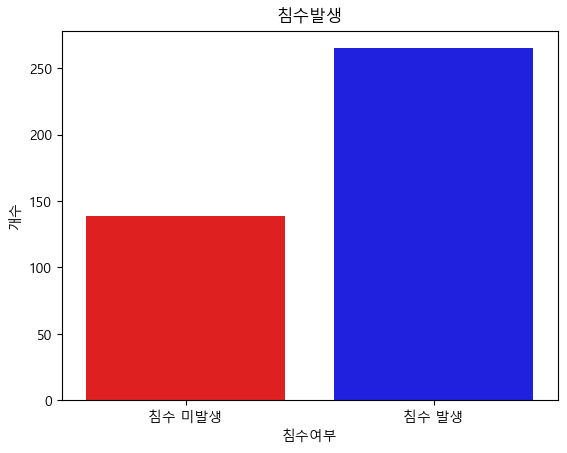

In [138]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.figure()
ax=sb.barplot(x=temp.index,y=temp["count"],palette=["red","blue"])
plt.title("침수발생")
plt.ylabel("개수")
ax.set_xticklabels(["침수 미발생","침수 발생"])
plt.show()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_7732\3501320764.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rename_col2)


Text(0.5, 1.0, '독립변수 Boxplot')

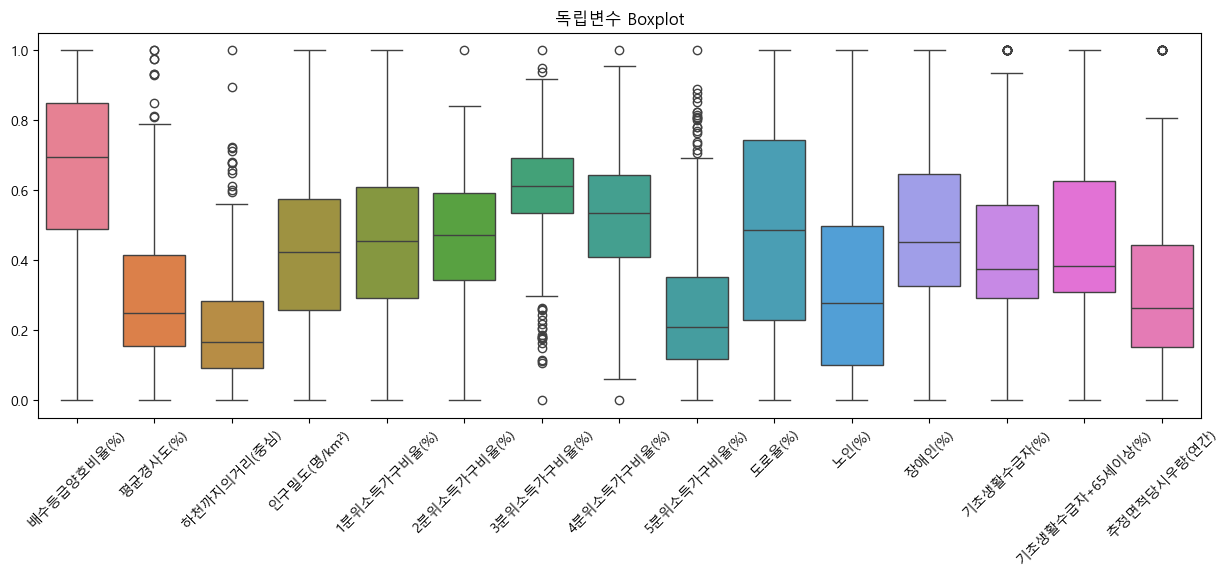

In [143]:
import sklearn.preprocessing as skpre
import pandas as pd
box_col=[x for x in 통합.columns if x not in ["GU_NAME","ADM_NM","제방","수문","침수여부"]]
rename_col=[x.replace("_per","(%)") for x in box_col]
rename_col1=[x.replace("율(%)","율") for x in rename_col]
rename_col2=[x.replace("율","율(%)") for x in rename_col1]
plt.figure(figsize=(15,5))
ax=sb.boxplot(pd.DataFrame(skpre.minmax_scale(통합[box_col]),columns=rename_col))
plt.xticks(rotation=45)
ax.set_xticklabels(rename_col2)
plt.title("독립변수 Boxplot")

----------

## 모델생성

In [48]:
import sklearn.tree as sktree
import sklearn.preprocessing as skpre
import numpy as np
import sklearn.model_selection as skmod
import matplotlib.pyplot as plt
np.random.seed(10)
plt.rcParams['font.family']="Malgun Gothic"

In [49]:
# feature_cols=['배수등급양호비율', '제방', '수문', '암거', '평균경사도(%)',
#        '하천까지의거리(중심)', '인구밀도(명/km²)', '도로율', '노인_per', '장애인_per', '기초생활수급자_per',
#        '기초생활수급자+65세이상_per', '추정시우량(연간)']
target_cols=["침수여부"]
feature_cols=통합.columns.difference(["GU_NAME","ADM_NM"]+target_cols)
feature_cols

Index(['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per', '도로율',
       '배수등급양호비율', '수문', '인구밀도(명/km²)', '장애인_per', '제방', '추정면적당시우량(연간)',
       '평균경사도(%)', '하천까지의거리(중심)'],
      dtype='object')

In [50]:
train,test=skmod.train_test_split(통합,train_size=0.7,random_state=10)

In [51]:
params_model=sktree.DecisionTreeClassifier(criterion="entropy",random_state=10)
params_model.fit(X=train[feature_cols],y=train[target_cols])

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [52]:
params_model.score(X=test[feature_cols],y=test[target_cols])

0.7213114754098361

In [53]:
print("max_depth :",params_model.get_depth())
print("max_sample_size :",params_model.get_n_leaves())

max_depth : 13
max_sample_size : 54


In [54]:
plt.figure()
sktree.plot_tree(params_model,filled=True)
plt.savefig("tree.png",dpi=1000,bbox_inches='tight')
plt.close()

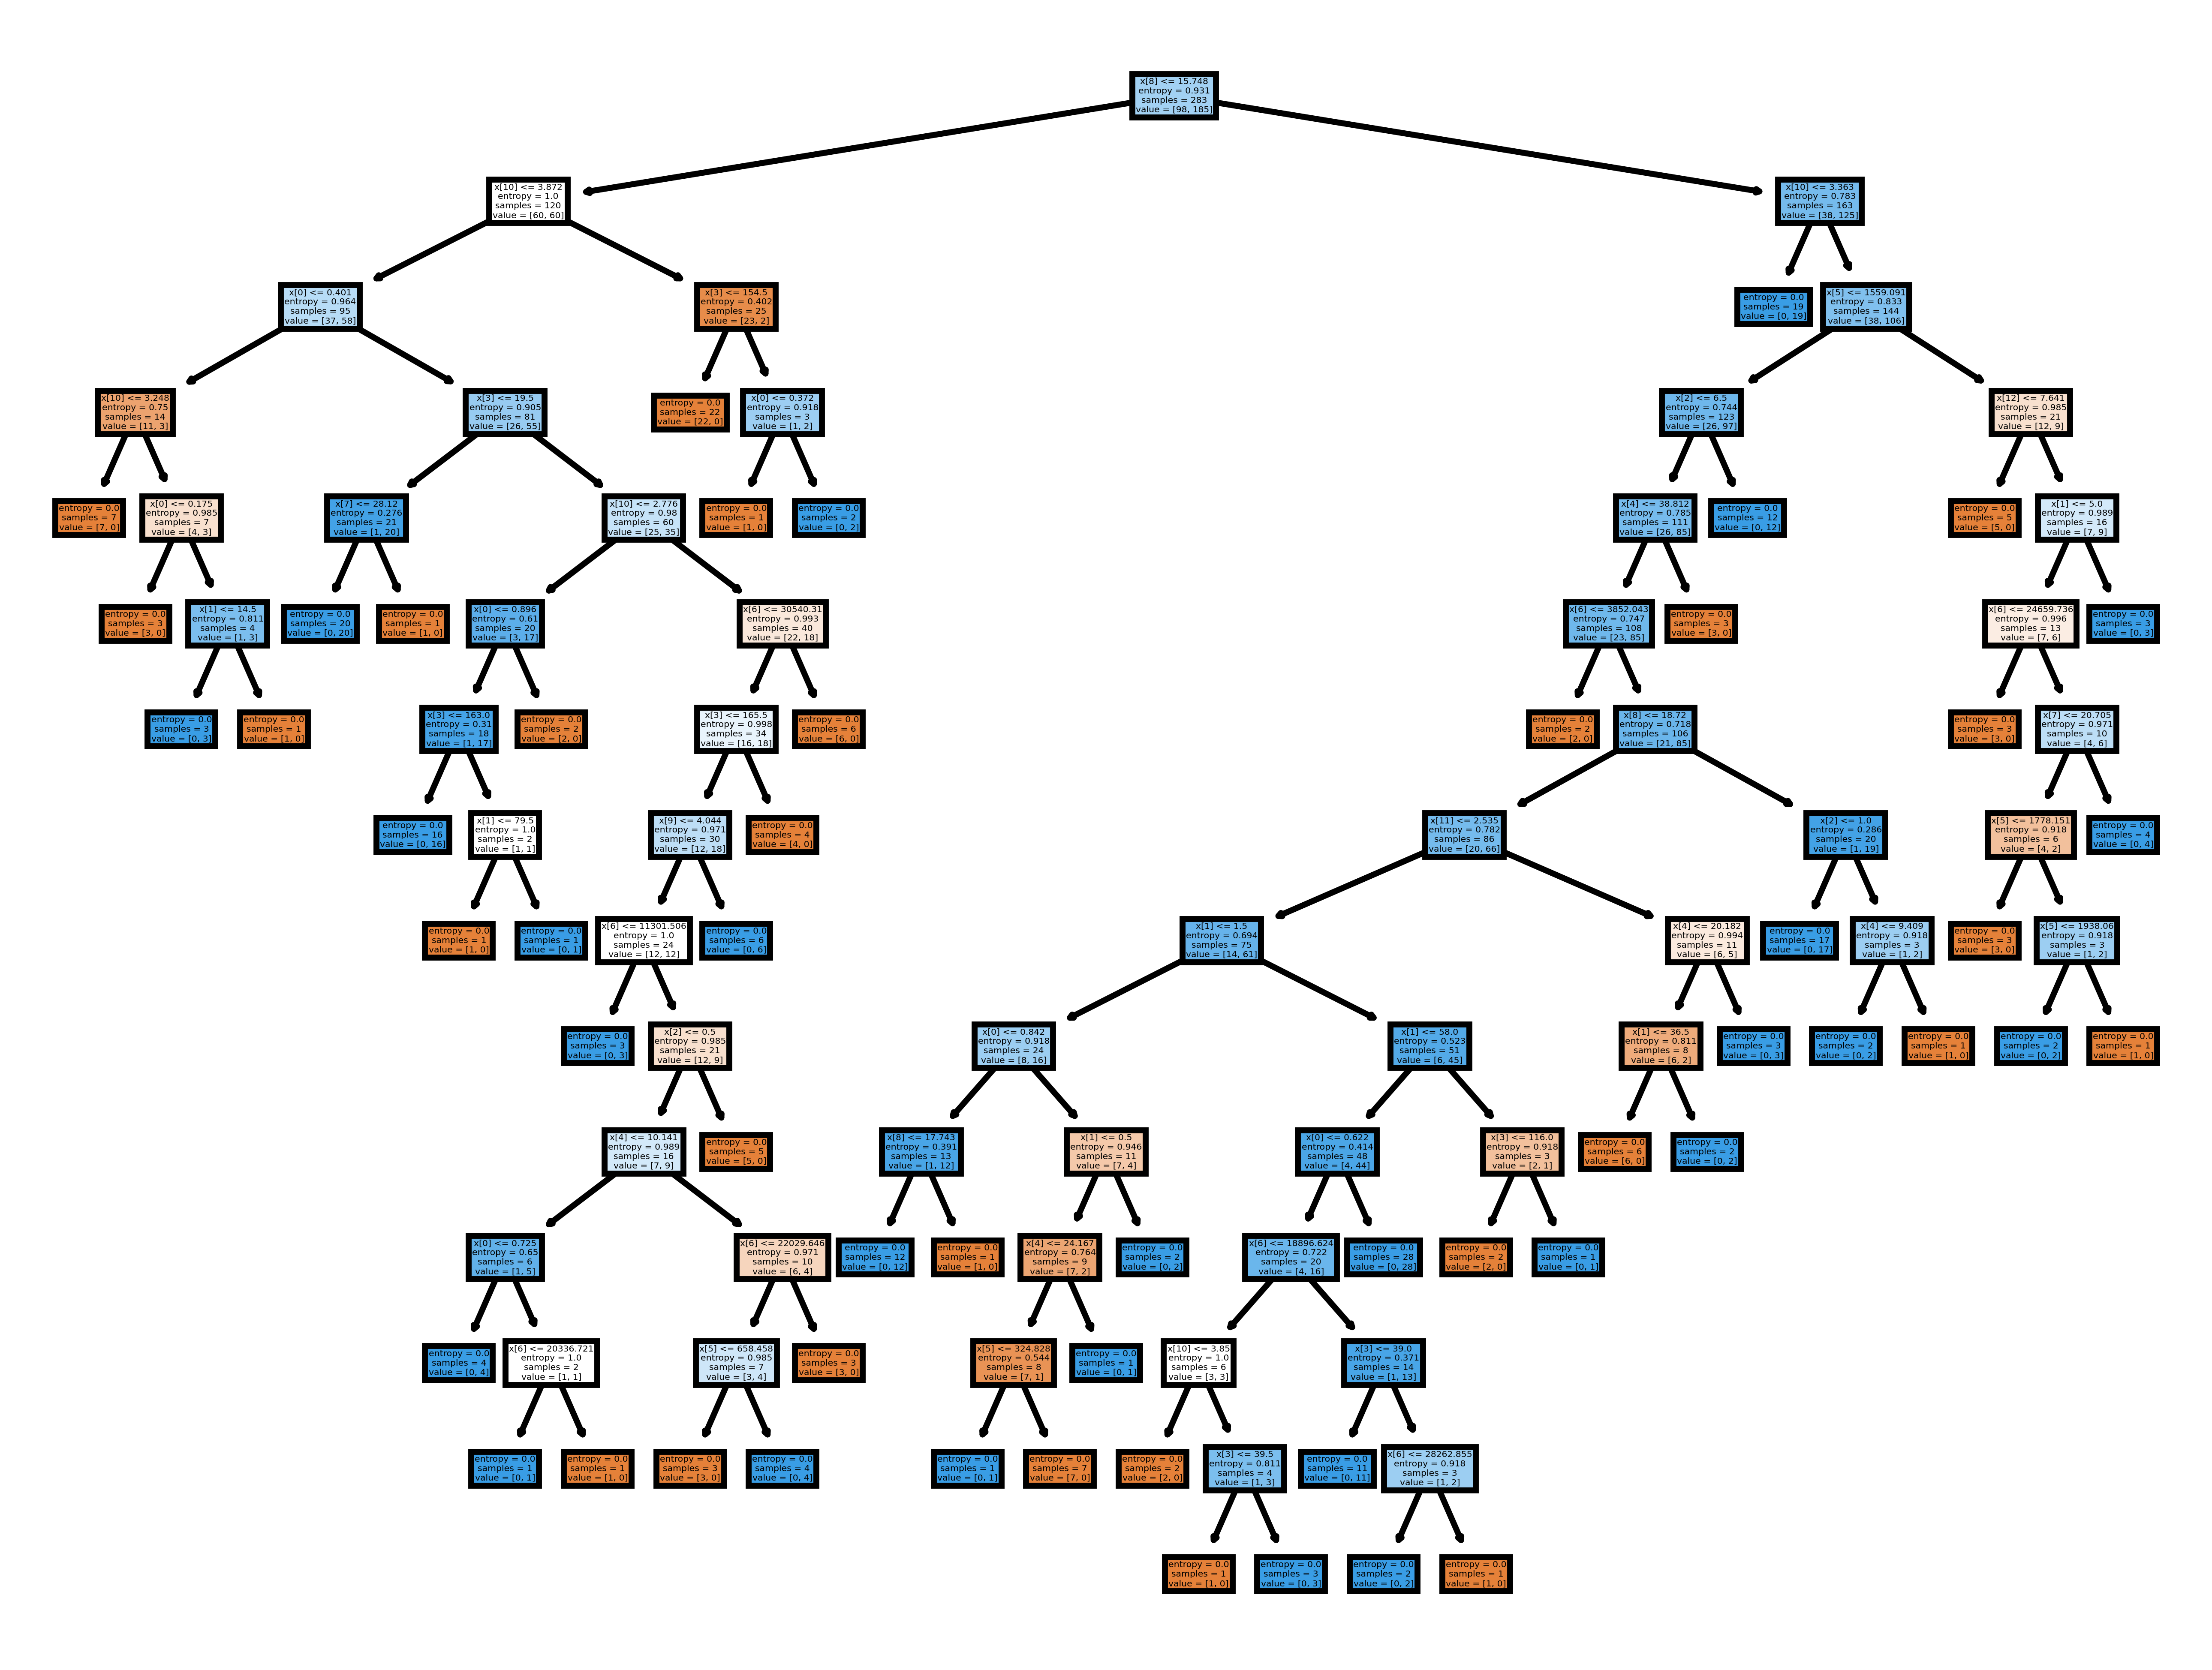

In [55]:
# 위와 같은 과정을 진행할것.
params_model=sktree.DecisionTreeClassifier(criterion="entropy")
params_model.fit(X=통합[feature_cols],y=통합[target_cols])
max_depth,max_sample_size=params_model.get_depth(),params_model.get_n_leaves()
print("max_depth :",params_model.get_depth())
print("max_sample_size :",params_model.get_n_leaves())

max_depth : 15
max_sample_size : 68


### 파라미터 최적화

random_search 로 탐색해보겠음..
- 학습 500번
- cv=10

test 사이즈와 똑같이 나누기

-------

In [56]:
import scipy as sp

In [57]:
params={"max_depth":sp.stats.randint(low=2,high=max_depth),"min_samples_split":sp.stats.randint(low=2,high=max_sample_size)}
grid_tree=sktree.DecisionTreeClassifier(criterion="entropy",random_state=10)
Random_model=skmod.RandomizedSearchCV(grid_tree,param_distributions=params,cv=3,random_state=10,n_iter=500,n_jobs=-1
                                      ,scoring="accuracy")
Random_model.fit(X=통합[feature_cols],y=통합[target_cols])

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    random_state=10),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000224BC99EF60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000224BC99D6A0>},
                   random_state=10, scoring='accuracy')

In [58]:
통합_best_params=Random_model.best_params_
print('결과 :',Random_model.best_params_)

결과 : {'max_depth': 4, 'min_samples_split': 2}


위의 과정를 토대로 의사결정나무를 만들것

### 부트스트랩
40개의 데이터 셋 구현 -> 침수여부의 층화추출이 이루어져야 됨            
36.8%의 데이터(약 1/3)가 검증 데이터로 변환됨.          
위의 파라미터는 train_size가 다르므로 cv값을 고려했어야했음

In [59]:
for i in range(40):
    eval(f'np.random.seed({i+1})')

In [60]:
import sklearn.utils as skuti
acc_list=[]
best_params=[]
# tree_model=sktree.DecisionTreeClassifier(criterion="entropy",max_depth=sub_best_params["max_depth"]
#                                          ,min_samples_split=sub_best_params["min_samples_split"],
#                                    random_state=10)
for i in range(11,11+40):
    resample_data=skuti.resample(통합,replace=True,random_state=i,stratify=통합[target_cols]) #학습데이터
    resample_data.drop_duplicates("ADM_NM",inplace=True)
    test_data=통합.loc[list(set(통합.index)-set(resample_data.index))] #검증데이터

    #random search
    params={"max_depth":sp.stats.randint(low=2,high=max_depth),"min_samples_split":sp.stats.randint(low=2,high=max_sample_size)}
    grid_tree=sktree.DecisionTreeClassifier(criterion="entropy",random_state=10)
    sub_Random_model=skmod.RandomizedSearchCV(estimator=grid_tree,
                                            param_distributions=params,
                                            scoring="accuracy",
                                            random_state=10,
                                            cv=10, n_iter=300,n_jobs=-1)
    sub_Random_model.fit(X=resample_data[feature_cols],y=resample_data[target_cols])
    tree_model=sub_Random_model.best_estimator_
    # tree_model.fit(X=resample_data[feature_cols],y=resample_data[target_cols]) #학습
    acc_list.append(tree_model.score(X=test_data[feature_cols],y=test_data[target_cols]))
    best_params.append(sub_Random_model.best_params_)

In [61]:
나무결과=pd.DataFrame(acc_list).rename(columns={0:'accuracy'})
나무결과["테스트_오차율"]=1-나무결과["accuracy"]
나무결과.sort_values(by="테스트_오차율",inplace=True)

In [62]:
best_params

[{'max_depth': 4, 'min_samples_split': 13},
 {'max_depth': 9, 'min_samples_split': 30},
 {'max_depth': 4, 'min_samples_split': 17},
 {'max_depth': 9, 'min_samples_split': 52},
 {'max_depth': 9, 'min_samples_split': 3},
 {'max_depth': 12, 'min_samples_split': 6},
 {'max_depth': 11, 'min_samples_split': 31},
 {'max_depth': 3, 'min_samples_split': 51},
 {'max_depth': 4, 'min_samples_split': 27},
 {'max_depth': 4, 'min_samples_split': 32},
 {'max_depth': 14, 'min_samples_split': 16},
 {'max_depth': 6, 'min_samples_split': 22},
 {'max_depth': 4, 'min_samples_split': 2},
 {'max_depth': 7, 'min_samples_split': 6},
 {'max_depth': 6, 'min_samples_split': 11},
 {'max_depth': 5, 'min_samples_split': 2},
 {'max_depth': 7, 'min_samples_split': 66},
 {'max_depth': 5, 'min_samples_split': 27},
 {'max_depth': 12, 'min_samples_split': 30},
 {'max_depth': 9, 'min_samples_split': 30},
 {'max_depth': 10, 'min_samples_split': 10},
 {'max_depth': 8, 'min_samples_split': 25},
 {'max_depth': 4, 'min_samples_s

In [63]:
나무결과

,accuracy,테스트_오차율
35,0.778571,0.221429
8,0.769784,0.230216
9,0.748299,0.251701
2,0.748148,0.251852
3,0.744966,0.255034
31,0.740506,0.259494
14,0.740000,0.260000
30,0.737226,0.262774
34,0.736111,0.263889
17,0.733333,0.266667


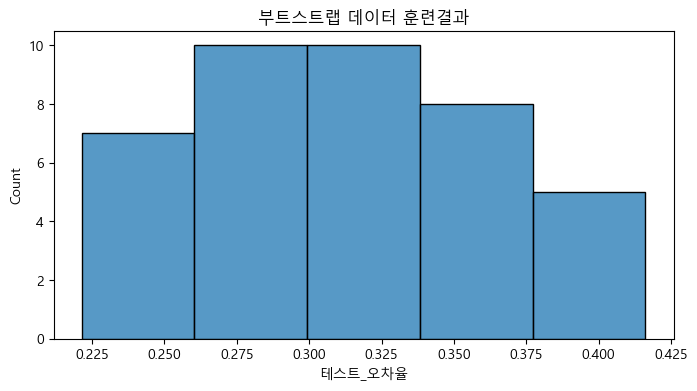

In [132]:
import seaborn as sb
plt.figure(figsize=(8,4))
plt.title("부트스트랩 데이터 훈련결과")
sb.histplot(x=나무결과["테스트_오차율"],bins=5)
plt.show()
plt.ylabel("모델 수")
plt.close()

#### 가설검정
일반화 오차율

In [65]:
나무결과["테스트_오차율"].mean()

0.31341190392274537

In [66]:
#나무결과[["테스트_오차율"]]

In [129]:
sp.stats.ttest_1samp(나무결과["테스트_오차율"],0.31)

TtestResult(statistic=0.43371250067404327, pvalue=0.6668870029812838, df=39)

일반화 오차율은 34%로 예상됨.           
즉, 일반화 accuracy는 66%

## 결과해석

In [182]:
final_tree_model=sktree.DecisionTreeClassifier(max_depth=Random_model.best_params_["max_depth"]
                                               ,min_samples_split=Random_model.best_params_["min_samples_split"]
                                               ,random_state=10
                                               ,criterion="entropy")
final_tree_model.fit(X=통합[feature_cols],y=통합[target_cols])

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=10)

In [183]:
info_result=pd.DataFrame(list(zip(final_tree_model.feature_names_in_,final_tree_model.feature_importances_))).rename(columns={0:"feature_name",1:"infomation_gain"})
info_result["infomation_gain"]=info_result["infomation_gain"].apply(lambda x:x*100)
info_result.sort_values(by="infomation_gain",ascending=False,inplace=True)
info_result.to_csv("./information_gain.csv")

In [178]:
#info_result
box_col=info_result["feature_name"]
rename_col=[x.replace("_per","(%)") for x in box_col]
rename_col1=[x.replace("율(%)","율") for x in rename_col]
rename_col2=[x.replace("율","율(%)") for x in rename_col1]
info_result["feature_name"]=rename_col2
info_result.reset_index(inplace=True)

In [179]:
info_result[["feature_name","infomation_gain"]]

,feature_name,infomation_gain
0,기초생활수급자(%),36.145587
1,노인(%),20.793080
2,2분위소득가구비율(%),12.349692
3,장애인(%),9.955820
4,5분위소득가구비율(%),8.484826
5,인구밀도(명/km²),8.192650
6,하천까지의거리(중심),4.078344
7,평균경사도(%),0.000000
8,추정면적당시우량(연간),0.000000
9,제방,0.000000


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_7732\167227608.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(rename_col2)


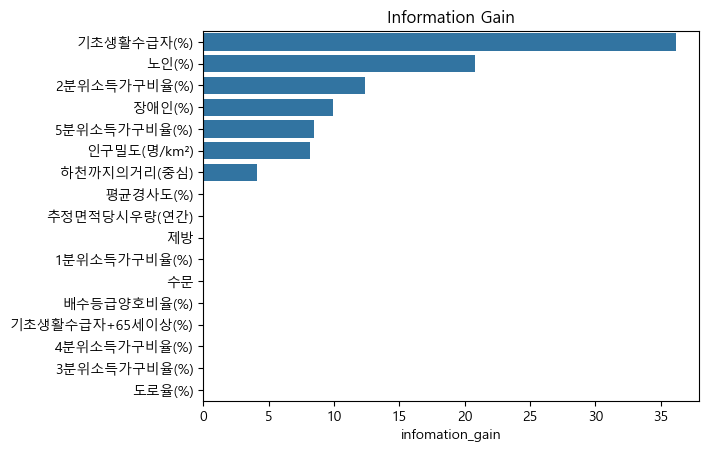

In [180]:
plt.figure()
ax=sb.barplot(x=info_result["infomation_gain"],y=info_result["feature_name"])
box_col=info_result["feature_name"]
rename_col=[x.replace("_per","(%)") for x in box_col]
rename_col1=[x.replace("율(%)","율") for x in rename_col]
rename_col2=[x.replace("율","율(%)") for x in rename_col1]
ax.set_yticklabels(rename_col2)
plt.title("Information Gain")
plt.ylabel("")
plt.show()
plt.close()

In [188]:
final_tree_model.feature_names_in_

array(['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per',
       '도로율', '배수등급양호비율', '수문', '인구밀도(명/km²)', '장애인_per', '제방',
       '추정면적당시우량(연간)', '평균경사도(%)', '하천까지의거리(중심)'], dtype=object)

In [190]:
plt.figure()
box_col=final_tree_model.feature_names_in_
rename_col=[x.replace("_per","(%)") for x in box_col]
rename_col1=[x.replace("율(%)","율") for x in rename_col]
rename_col2=[x.replace("율","율(%)") for x in rename_col1]
sktree.plot_tree(final_tree_model,filled=True,feature_names=rename_col2,proportion=False)
plt.savefig("final_tree.png",dpi=1000,bbox_inches='tight')
plt.close()

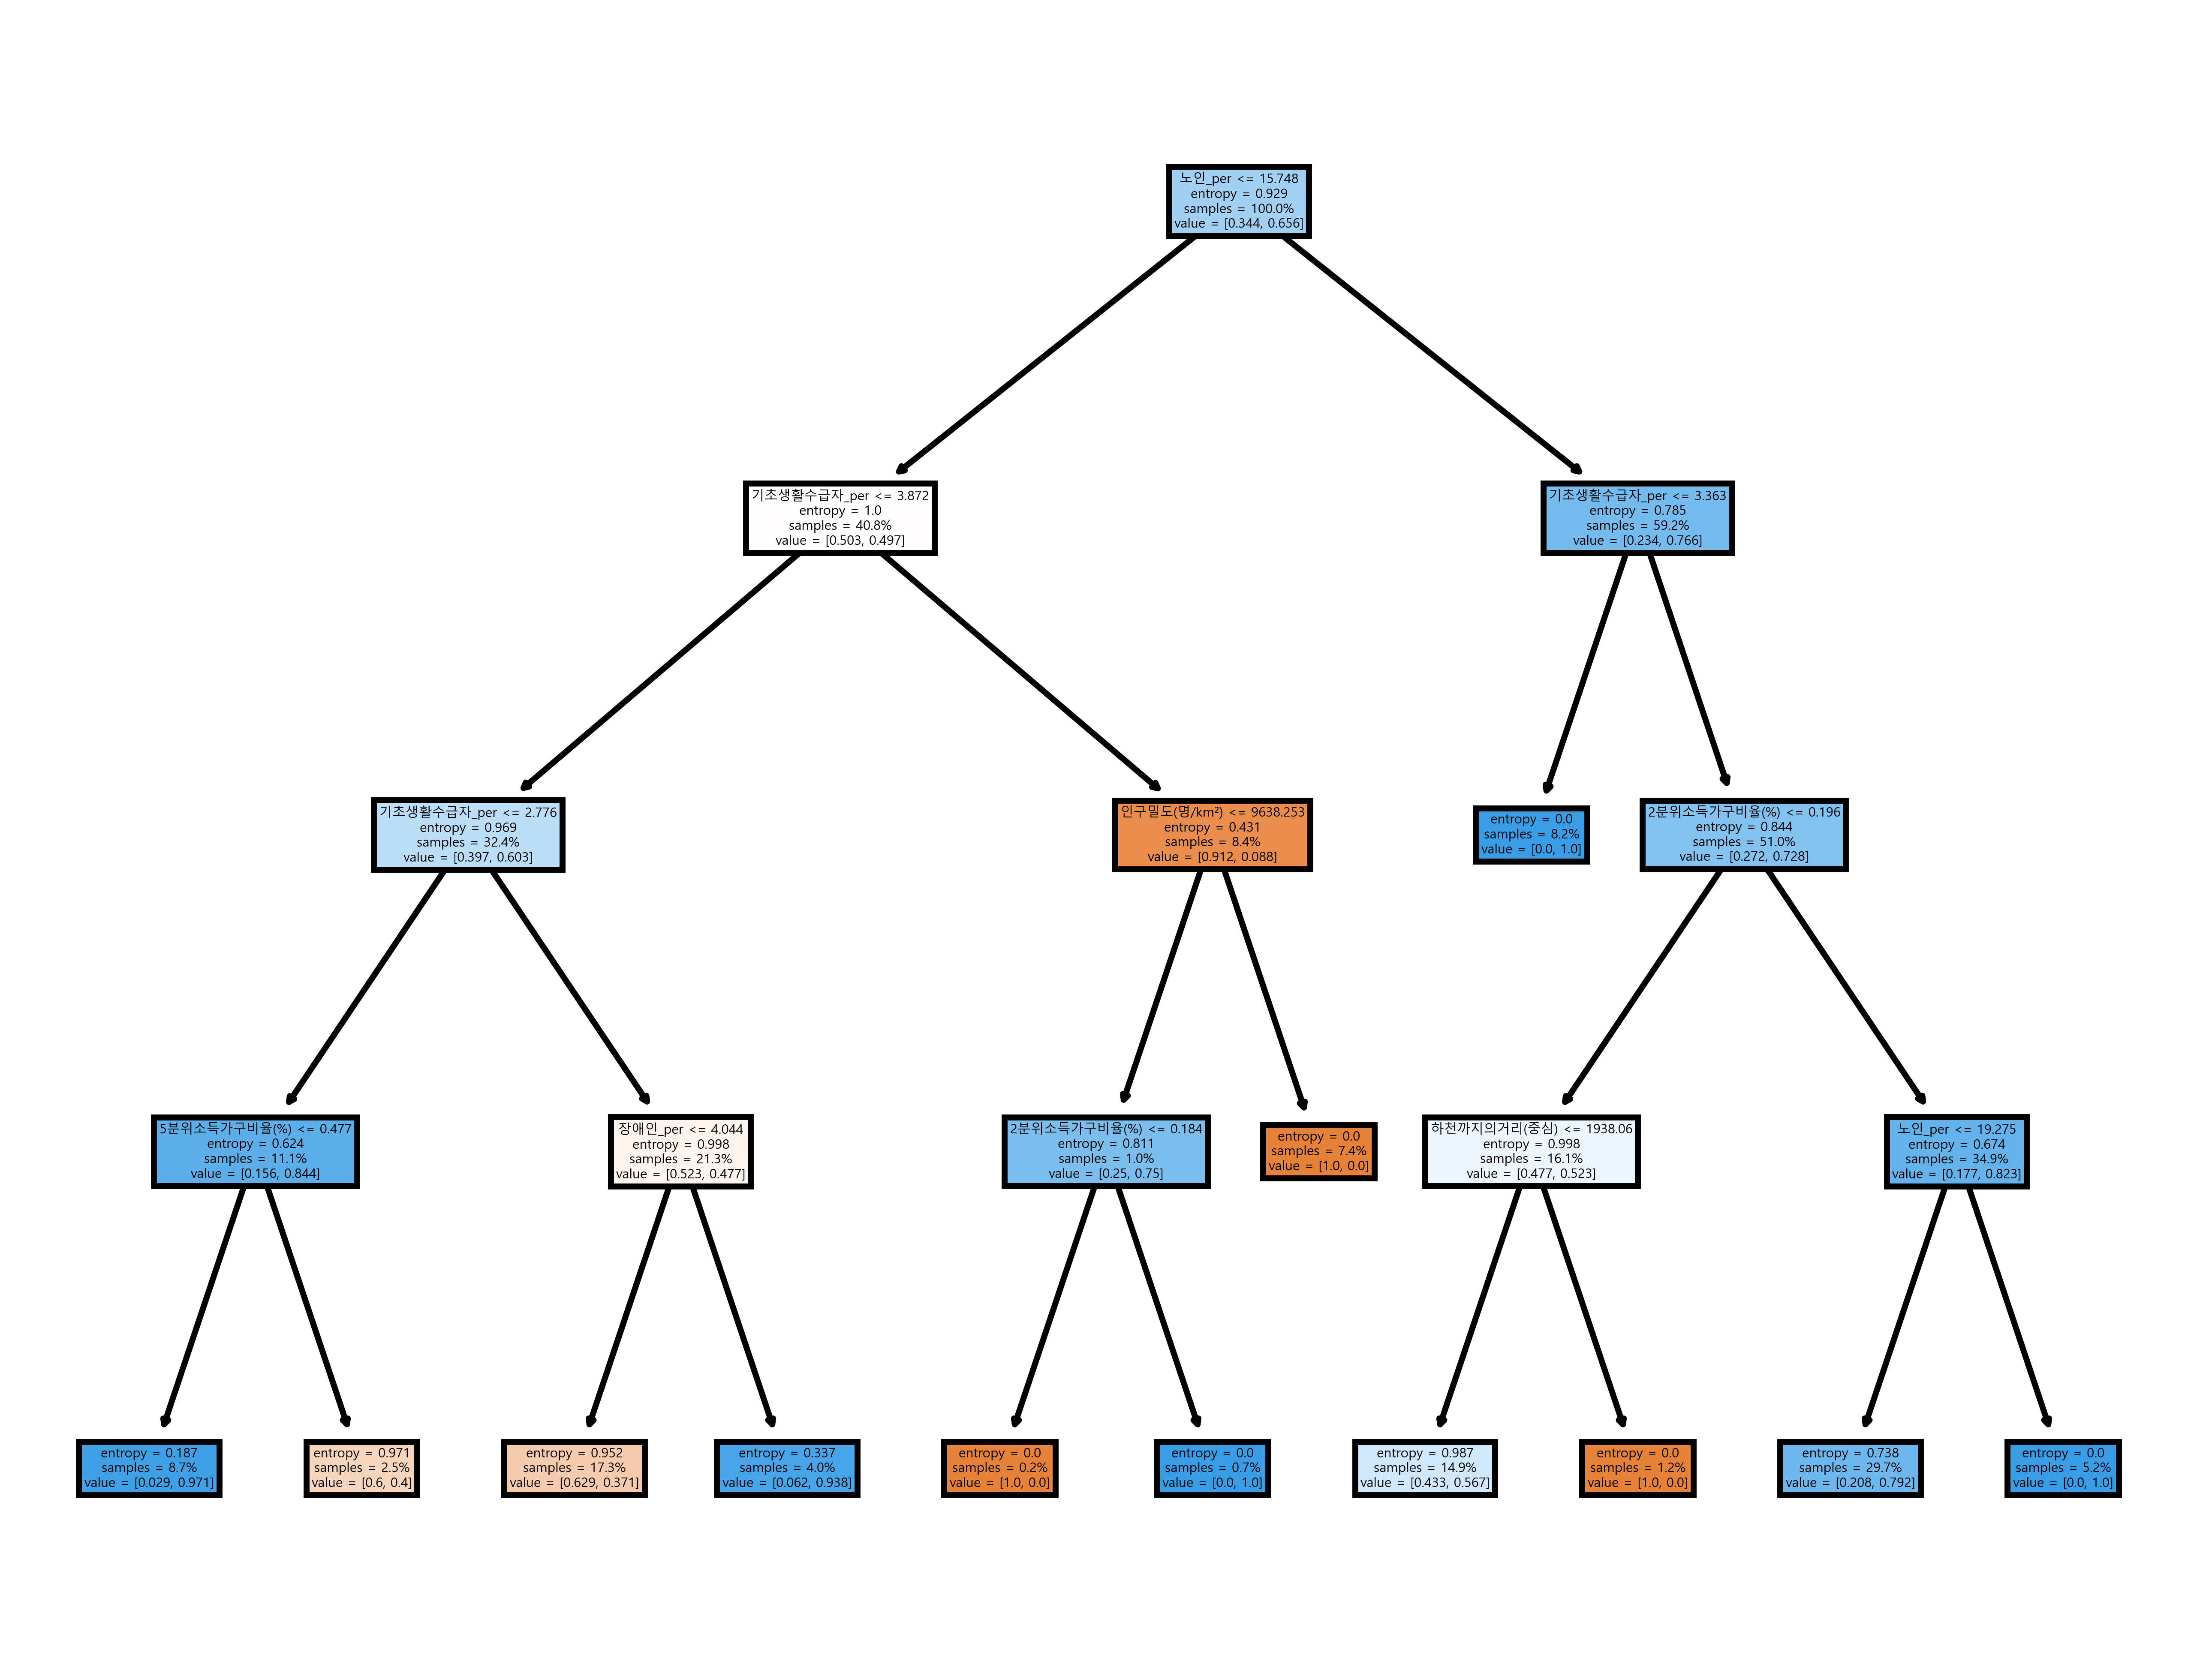

In [168]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree in .dot format
dot_data = export_graphviz(final_tree_model, out_file=None, 
                           feature_names=rename_col2,
                           filled=True,
                           proportion=False,
                           fontname="Malgun Gothic")

# Create a Graphviz object from the .dot data with the specified font
graph = graphviz.Source(dot_data, format="png", engine="dot", encoding="utf-8")

# Render the tree to a file (e.g., PNG)
output_file = "final_tree_graphviz.png"
graph.render(output_file)


'final_tree_graphviz.png.png'